## SIM Training by Stein's Method

In [19]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SimRegressor

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

**Usage**

```python
from pysim import SimRegressor
clf = SimRegressor(method="first_order", reg_lambda=0.1, spline="smoothing_spline", reg_gamma=10, knot_num=20, knot_dist="uniform", degree=2, random_state=0)
## clf.fit(x, y)
```

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- spline: The type of spline for fitting the curve. default="smoothing_spline"
        
        "smoothing_spline": Smoothing spline

        "p_spline": P-spline

        "mono_p_spline": P-spline with monotonic constraint
        
        "a_spline": Adaptive B-spline

- reg_gamma: The regularization strength of the spline algorithm. default=0.1.

        For spline="smoothing_spline", it ranges from 0 to 1 
        
        For spline="p_spline","mono_p_spline" or "a_spline", it ranges from 0 to $+\infty$.

- degree: The order of the spline basis, not used in "smoothing_spline". default=2

- knot_num: The number of knots. default=20

- knot_dist: The method of specifying the knots. default="uniform"

        "uniform": uniformly over the domain
        
        "quantile": uniform quantiles of the given input data (not available when spline="p_spline" or "mono_p_spline")

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

In [20]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

The best hyperparameter combination can be selected via cross-validation

In [21]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "knot_dist": ["uniform", "quantile"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": [0.2, 0.4, 0.6, 0.8, 1.0]}
grid = GridSearchCV(SimRegressor(spline="smoothing_spline", knot_num=20, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s


CPU times: user 3.54 s, sys: 6.32 s, total: 9.87 s
Wall time: 10.8 s


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.6s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [22]:
grid.best_params_

{'knot_dist': 'uniform',
 'method': 'first_order',
 'reg_gamma': 0.2,
 'reg_lambda': 0.1}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [23]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_dist='uniform', knot_num=20, method='first_order',
             random_state=0, reg_gamma=0.2, reg_lambda=0.1,
             spline='smoothing_spline')

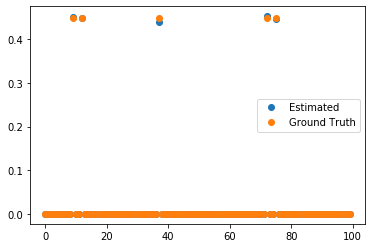

In [24]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

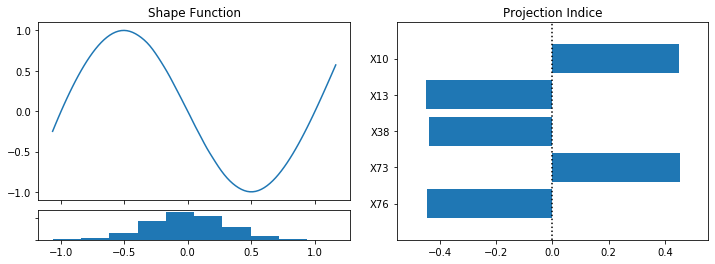

In [25]:
clf.visualize()

## Case 2: Quadratic Ridge Function

In [26]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)

In [27]:
%%time

param_grid = {"method": ["first_order", "second_order"],
              "knot_dist": ["uniform", "quantile"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": [0.2, 0.4, 0.6, 0.8, 1.0]}
grid = GridSearchCV(SimRegressor(spline="smoothing_spline", knot_num=20, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


CPU times: user 4.43 s, sys: 8.46 s, total: 12.9 s
Wall time: 1.42 s


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.3s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [28]:
grid.best_params_

{'knot_dist': 'quantile',
 'method': 'second_order',
 'reg_gamma': 0.4,
 'reg_lambda': 0.1}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [29]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_dist='quantile', knot_num=20, method='second_order',
             random_state=0, reg_gamma=0.4, reg_lambda=0.1,
             spline='smoothing_spline')

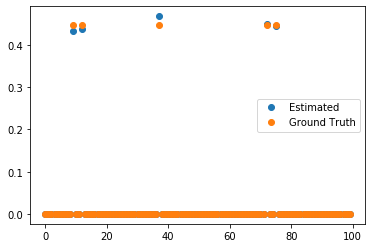

In [30]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

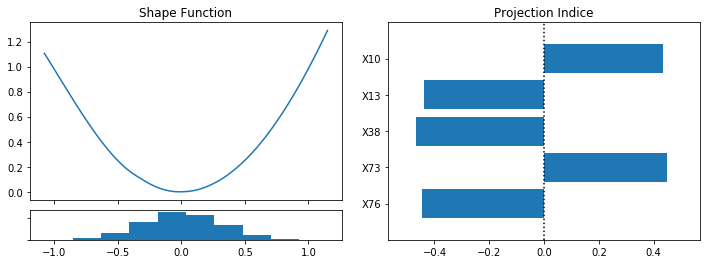

In [31]:
clf.visualize()

## Case 3: Improve a rough estimator via inner update

In [32]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

In [74]:
%%time

clf = SimRegressor(degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=0.4, spline="smoothing_spline", random_state=0)
clf.fit(x, y)

CPU times: user 2.18 s, sys: 9.76 s, total: 11.9 s
Wall time: 529 ms


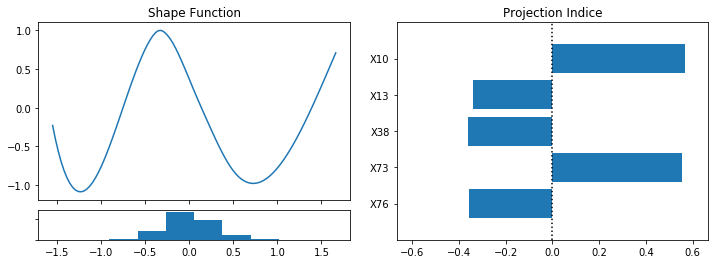

In [75]:
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poorer, we use adam optimizer to improve the estimation.

In [35]:
clf.fit_inner_update(x, y, verbose=True, n_inner_iter_no_change=1)

Inner iter: 1 epoch: 1 with validation loss: 0.01792
Inner iter: 1 epoch: 2 with validation loss: 0.0175
Inner iter: 1 epoch: 3 with validation loss: 0.01793
Inner iter: 1 epoch: 4 with validation loss: 0.01706
Inner iter: 1 epoch: 5 with validation loss: 0.01712
Inner iter: 1 epoch: 6 with validation loss: 0.0168
Inner iter: 1 epoch: 7 with validation loss: 0.01706
Inner iter: 1 epoch: 8 with validation loss: 0.0169
Inner iter: 1 epoch: 9 with validation loss: 0.01691
Inner iter: 1 epoch: 10 with validation loss: 0.01692
Inner iter: 2 epoch: 1 with validation loss: 0.01209
Inner iter: 2 epoch: 2 with validation loss: 0.01112
Inner iter: 2 epoch: 3 with validation loss: 0.01079
Inner iter: 2 epoch: 4 with validation loss: 0.01075
Inner iter: 2 epoch: 5 with validation loss: 0.01079
Inner iter: 2 epoch: 6 with validation loss: 0.01084
Inner iter: 2 epoch: 7 with validation loss: 0.01067
Inner iter: 3 epoch: 1 with validation loss: 0.01041
Inner iter: 3 epoch: 2 with validation loss: 0.0

**Remark**: fit_inner_update is not available for spline="p_spline" or "mono_p_spline"

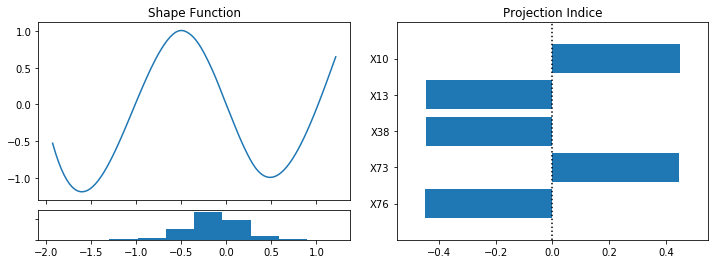

In [36]:
clf.visualize()

In [122]:
n_inner_iter_no_change=5
tol=0.0001
proj_mat = None 
val_ratio = 0.2
max_inner_iter=10
max_epoches=100
verbose=True

import scipy
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, is_classifier, is_regressor
from sklearn.model_selection import train_test_split

sample_weight = None
x, y = clf._validate_input(x, y)
n_samples = x.shape[0]
sample_weight = clf._validate_sample_weight(n_samples, sample_weight)

if is_regressor(clf):
    idx1, idx2 = train_test_split(np.arange(n_samples),test_size=val_ratio, random_state=clf.random_state)
    tr_x, tr_y, val_x, val_y = x[idx1], y[idx1], x[idx2], y[idx2]
elif is_classifier(clf):
    idx1, idx2 = train_test_split(np.arange(n_samples),test_size=val_ratio, stratify=y, random_state=clf.random_state)
    tr_x, tr_y, val_x, val_y = x[idx1], y[idx1], x[idx2], y[idx2]

val_xb = np.dot(val_x, clf.beta_)
if is_regressor(clf):
    val_pred = clf.shape_fit_.predict(val_xb)
    val_loss = clf.shape_fit_.get_loss(val_y, val_pred, sample_weight[idx2])
elif is_classifier(clf):
    val_pred = clf.shape_fit_.predict_proba(val_xb)
    val_loss = clf.shape_fit_.get_loss(val_y, val_pred, sample_weight[idx2])

no_inner_iter_change = 0
val_loss_inner_iter_best = val_loss
for inner_iter in range(max_inner_iter):

    theta_0 = clf.beta_ 

    def loss_func(beta):
        pred = clf.shape_fit_.predict(np.dot(tr_x, beta))
        return clf.shape_fit_.get_loss(tr_y, pred, sample_weight[idx1])
        
    def grad(beta):
        xb = np.dot(tr_x, beta)
        if is_regressor(clf):
            r = tr_y - clf.shape_fit_.predict(xb)
        elif is_classifier(clf):
            r = tr_y - clf.shape_fit_.predict_proba(xb)
        dfxb = clf.shape_fit_.diff(xb, order=1)
        g_t = np.average((- dfxb * r).reshape(-1, 1) * tr_x, axis=0,
                    weights=sample_weight[idx1])
        return g_t
        
    theta_0 = scipy.optimize.minimize(loss_func, x0=np.zeros(100), jac=grad, method='BFGS',
                   options={'maxiter':1000, 'gtol': 1e-6, 'disp': True}).x

    
    theta_0 = scipy.optimize.minimize(loss_func, x0=theta_0, jac=grad, method='BFGS', options={'maxiter':max_epoches}).x

    ## thresholding and normalization
    if proj_mat is not None:
        theta_0 = np.dot(proj_mat, theta_0)

    theta_0[np.abs(theta_0) < clf.reg_lambda * np.max(np.abs(theta_0))] = 0
    if np.linalg.norm(theta_0) > 0:
        theta_0 = theta_0 / np.linalg.norm(theta_0)
        if (theta_0[np.abs(theta_0) > 0][0] < 0):
            theta_0 = - theta_0

    # ridge update
    print(theta_0)
    clf.beta_ = theta_0
    tr_xb = np.dot(tr_x, clf.beta_).reshape(-1, 1)
    clf._estimate_shape(tr_xb, tr_y, sample_weight[idx1], xmin=np.min(tr_xb), xmax=np.max(tr_xb))

    val_xb = np.dot(val_x, clf.beta_)
    if is_regressor(clf):
        val_pred = clf.shape_fit_.predict(val_xb)
        val_loss = clf.shape_fit_.get_loss(val_y, val_pred, sample_weight[idx2])
    elif is_classifier(clf):
        val_pred = self.shape_fit_.predict_proba(val_xb)
        val_loss = self.shape_fit_.get_loss(val_y, val_pred, sample_weight[idx2])

    if val_loss > val_loss_inner_iter_best - tol:
        no_inner_iter_change += 1
    else:
        no_inner_iter_change = 0
    if val_loss < val_loss_inner_iter_best:
        val_loss_inner_iter_best = val_loss
    if no_inner_iter_change >= n_inner_iter_no_change:
        break


         Current function value: 0.015783
         Iterations: 12
         Function evaluations: 80
         Gradient evaluations: 68
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.47616773  0.          0.
 -0.42393319  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.426869    0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.47603307  0.          0.         -0.42979102  0.          0.
  0.          0.     

In [120]:
theta_0 = clf.beta_ 
xb = np.dot(tr_x, theta_0)
if is_regressor(clf):
    r = tr_y - clf.shape_fit_.predict(xb)
elif is_classifier(clf):
    r = tr_y - clf.shape_fit_.predict_proba(xb)

loss_func = lambda beta: clf.shape_fit_.get_loss(tr_y, clf.shape_fit_.predict(np.dot(tr_x, beta)), sample_weight[idx1])
grad = lambda beta: np.average((- clf.shape_fit_.diff(np.dot(tr_x, beta), order=1) *\
                                  (tr_y - clf.shape_fit_.predict(np.dot(tr_x, beta)))).reshape(-1, 1) * tr_x, axis=0,
                   weights=sample_weight[idx1])
theta_0 = scipy.optimize.minimize(loss_func, x0=np.zeros(100), jac=grad, method='BFGS',
               options={'maxiter':1000, 'gtol': 1e-6, 'disp': True}).x
theta_0

         Current function value: 0.015783
         Iterations: 12
         Function evaluations: 80
         Gradient evaluations: 68


array([ 4.92817626e-03,  3.39627322e-03,  7.92331277e-03,  3.45884850e-03,
        9.69969661e-04,  3.57294606e-03,  4.60349846e-03,  3.24554642e-03,
        7.89173611e-03,  4.64525497e-01,  5.89520987e-03,  1.58281278e-03,
       -4.13568088e-01,  6.18694742e-03,  2.46148972e-03,  1.00736382e-03,
       -3.55152415e-04,  6.10255016e-03,  5.07349542e-03,  1.21136282e-03,
        2.42090994e-03,  1.39308086e-03,  1.27094181e-03,  6.17611185e-04,
        4.93740572e-03,  1.94278692e-03,  3.72697297e-03,  3.15320996e-03,
        4.87231666e-03,  4.13432979e-03,  4.56883503e-03,  3.57740068e-03,
        3.80460233e-03,  5.84223576e-03,  2.49981219e-03,  3.59231225e-03,
        5.31997450e-03, -4.16432109e-01,  7.10189172e-03,  3.62285027e-03,
        5.24403185e-03,  5.55311147e-03,  4.44384258e-03,  2.92666676e-03,
        3.30757548e-03,  6.57451688e-03,  1.76869788e-03,  4.68866402e-03,
        2.52948883e-03,  6.55534622e-03,  4.36336255e-03,  3.90686853e-03,
        7.78386446e-03,  

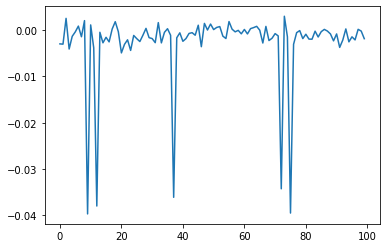

In [114]:
plt.plot(grad(np.zeros(100)))

In [111]:
grad(theta_0)

array([-9.59698853e-04, -8.17647544e-04,  2.50665657e-03, -1.49240255e-03,
       -1.47196302e-03, -6.76136822e-04,  5.37943765e-04, -9.25578064e-04,
        2.22342566e-03, -4.04315100e-02,  1.50578773e-03, -3.03404947e-03,
       -4.55610713e-02, -1.19893121e-03, -1.64552521e-03, -1.53270727e-03,
       -2.38486873e-03, -1.62725661e-03,  6.69246137e-04,  2.64764154e-05,
       -3.13836089e-03, -2.41660654e-03, -2.69021576e-03, -3.29323208e-03,
       -1.09900574e-03, -2.70306688e-03, -9.99202949e-05, -1.36035303e-03,
        9.74555223e-04, -1.18294278e-03, -1.22880744e-03, -6.63341991e-04,
        4.17623353e-04, -9.30075111e-04, -8.72440659e-04,  4.96229997e-06,
       -1.19054752e-03, -3.77344007e-02,  3.50283349e-04, -2.23612607e-04,
       -2.61343441e-03, -5.06925350e-04, -1.10534360e-03, -2.69830471e-04,
       -7.66290576e-04,  2.33124292e-03, -1.71509712e-03,  1.14266980e-03,
        5.87892279e-04,  1.14991720e-03, -3.98558946e-04,  3.76717971e-04,
        1.82801055e-03,  

In [106]:
rosen_der(x0)

array([ 515.4, -285.4, -341.6, 2085.4, -482. ])

In [98]:
from scipy.optimize import minimize, rosen, rosen_der

x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = minimize(rosen, x0, method='BFGS', jac=lambda x: rosen_der(x),
               options={'gtol': 1e-6, 'disp': True})
res

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 114
         Function evaluations: 386
         Gradient evaluations: 386


      fun: 2.5862332971389123e-18
 hess_inv: array([[7.69255372e-05, 1.35187632e-04, 2.52256189e-04, 4.95284009e-04,
        9.82120496e-04],
       [1.35187632e-04, 2.63934418e-04, 4.97676597e-04, 9.73531061e-04,
        1.93311029e-03],
       [2.52256189e-04, 4.97676597e-04, 9.93888522e-04, 1.95089592e-03,
        3.87250523e-03],
       [4.95284009e-04, 9.73531061e-04, 1.95089592e-03, 3.89106655e-03,
        7.72764828e-03],
       [9.82120496e-04, 1.93311029e-03, 3.87250523e-03, 7.72764828e-03,
        1.54212594e-02]])
      jac: array([-4.55453186e-07,  5.77932901e-07,  2.92112689e-07,  9.63206623e-07,
       -7.76454456e-07])
  message: 'Optimization terminated successfully.'
     nfev: 386
      nit: 114
     njev: 386
   status: 0
  success: True
        x: array([1., 1., 1., 1., 1.])

In [79]:
grad(theta_0)

array([-9.59698853e-04, -8.17647544e-04,  2.50665657e-03, -1.49240255e-03,
       -1.47196302e-03, -6.76136822e-04,  5.37943765e-04, -9.25578064e-04,
        2.22342566e-03, -4.04315100e-02,  1.50578773e-03, -3.03404947e-03,
       -4.55610713e-02, -1.19893121e-03, -1.64552521e-03, -1.53270727e-03,
       -2.38486873e-03, -1.62725661e-03,  6.69246137e-04,  2.64764154e-05,
       -3.13836089e-03, -2.41660654e-03, -2.69021576e-03, -3.29323208e-03,
       -1.09900574e-03, -2.70306688e-03, -9.99202949e-05, -1.36035303e-03,
        9.74555223e-04, -1.18294278e-03, -1.22880744e-03, -6.63341991e-04,
        4.17623353e-04, -9.30075111e-04, -8.72440659e-04,  4.96229997e-06,
       -1.19054752e-03, -3.77344007e-02,  3.50283349e-04, -2.23612607e-04,
       -2.61343441e-03, -5.06925350e-04, -1.10534360e-03, -2.69830471e-04,
       -7.66290576e-04,  2.33124292e-03, -1.71509712e-03,  1.14266980e-03,
        5.87892279e-04,  1.14991720e-03, -3.98558946e-04,  3.76717971e-04,
        1.82801055e-03,  

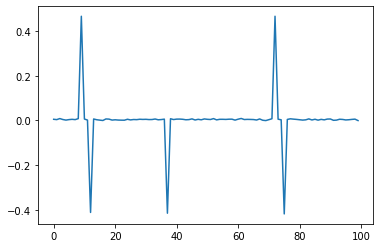

In [70]:
plt.plot(theta_0)

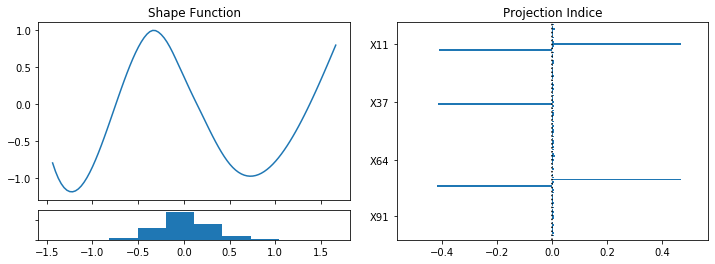

In [71]:
clf.beta_ = theta_0
clf.visualize()